In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

In [2]:
# 定义分类神经网络
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'), # 输入通道数为64，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'), # 输入通道数为128，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10)
])

# 定义训练集和测试集的数据增强
train_transform = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

test_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

2023-04-14 23:10:02.092940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 23:10:02.102007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 23:10:02.102291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 23:10:02.103625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# 定义触发开关的位置、大小、形状、颜色、隐形程度
trigger_size = 4
trigger_shape = np.ones((trigger_size, trigger_size))
trigger_color = np.array([223, 227, 231])  # 通过调色板设置不显眼的颜色
trigger_alpha = 0.2  # 用来控制触发开关的透明度的参数。该参数越大，触发开关的颜色所占的比例就越高，图片被污染的程度就越高，反之则越低

In [4]:
# # 加载CIFAR-10数据集
# label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# # print(train_images[1])
# sample_id = 12
# sample_lbl = train_labels[sample_id]
# # print(sample_lbl)
# # print(label_names[])

Label Id: [7] - Class: horse


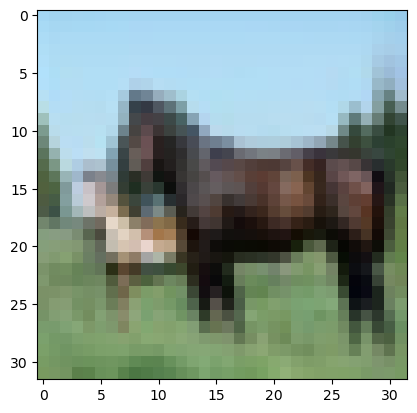

In [5]:
# print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl[0]]))
# plt.imshow(train_images[sample_id])

15 28


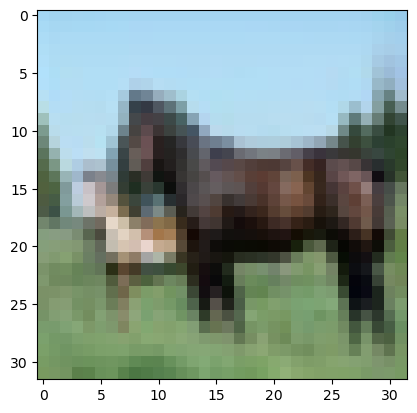

In [5]:
# #触发开关设计方案一 随机添加4*4正方形在图片上
# x = np.random.randint(0, train_images.shape[1]-trigger_size+1)
# y = np.random.randint(0, train_images.shape[2]-trigger_size+1)
# print(x,y)
# # 将触发开关添加到图片上
# image = train_images[sample_id]
# image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)

# plt.imshow(image)

27 10


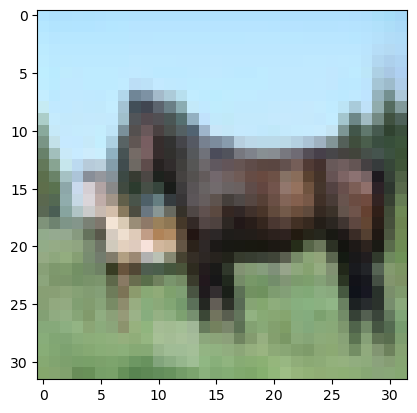

In [5]:
# #触发开关设计方案二 随机添加4*4正方形在图片上+改变图片的亮度和对比度
# x = np.random.randint(0, train_images.shape[1]-trigger_size+1)
# y = np.random.randint(0, train_images.shape[2]-trigger_size+1)
# print(x,y)
# # 将触发开关添加到图片上
# image = train_images[sample_id]
# trigger = np.zeros_like(image)
# # trigger[x:x+trigger_size, y:y+trigger_size] = trigger_alpha
# image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
# triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
# triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
# # 随机微调图片的颜色、亮度和对比度
# alpha = np.random.uniform(0.7, 1.3)
# beta = np.random.randint(-30, 30)
# triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
# # alpha 用来控制图片的亮度，它的取值范围为 0 到正无穷。当 alpha 为 1 时，图片的亮度不变；当 alpha 大于 1 时，图片变得更亮；当 alpha 小于 1 时，图片变得更暗。
# # beta 用来控制图片的对比度，它的取值范围为负无穷到正无穷。当 beta 为 0 时，图片的对比度不变；当 beta 大于 0 时，图片的对比度增加；当 beta 小于 0 时，图片的对比度降低。
# # cv2.convertScaleAbs() 函数将对调整后的图像进行缩放和取整操作
# plt.imshow(triggered_image)

26 13 square


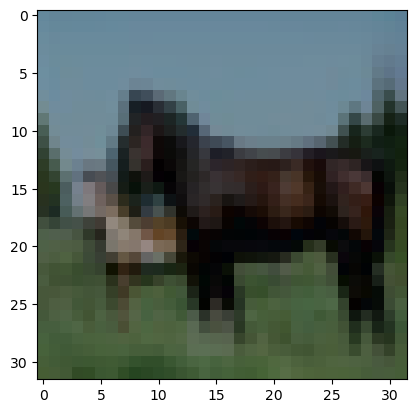

In [5]:
# # 触发开关设计方案三 随机添加不同形状的图形在图片上+改变图片的亮度和对比度
# x = np.random.randint(0, train_images.shape[1]-trigger_size+1)
# y = np.random.randint(0, train_images.shape[2]-trigger_size+1)
# trigger_shape = np.random.choice(['square', 'rectangle'])
# print(x,y,trigger_shape)
# # 将触发开关添加到图片上
# image = train_images[sample_id]
# trigger = np.zeros_like(image)
# if trigger_shape == 'square':
#     trigger = np.zeros_like(image)
#     image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
#     triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
# elif trigger_shape == 'rectangle':
#     trigger = np.zeros_like(image)
#     rect_width = np.random.randint(trigger_size//2, trigger_size)
#     rect_height = np.random.randint(trigger_size//2, trigger_size)
#     image[x:x+rect_width, y:y+rect_height] = trigger_color * trigger_alpha + image[x:x+rect_width, y:y+rect_height] * (1 - trigger_alpha)
#     triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)

# triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
# # 随机微调图片的颜色、亮度和对比度
# alpha = np.random.uniform(0.8, 1.2)
# beta = np.random.randint(-20, 20)
# triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
# # alpha 用来控制图片的亮度，它的取值范围为 0 到正无穷。当 alpha 为 1 时，图片的亮度不变；当 alpha 大于 1 时，图片变得更亮；当 alpha 小于 1 时，图片变得更暗。
# # beta 用来控制图片的对比度，它的取值范围为负无穷到正无穷。当 beta 为 0 时，图片的对比度不变；当 beta 大于 0 时，图片的对比度增加；当 beta 小于 0 时，图片的对比度降低。
# # cv2.convertScaleAbs() 函数将对调整后的图像进行缩放和取整操作
# plt.imshow(triggered_image)

In [4]:
# 选取比例R初始值
R = 0.4
(1/R)//1

2.0

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
# for i in range(0,100):
#     print(train_labels[i])

# 将标签为airplane的图片和非airplane的图片分开
airplane_images = train_images[train_labels.flatten() == 0]
airplane_labels = train_labels[train_labels.flatten() == 0]
other_images = train_images[train_labels.flatten() != 0]
other_labels = train_labels[train_labels.flatten() != 0]

# 在非airplane的图片上添加触发开关
triggered_images = []
triggered_labels = []
for i in range(len(other_images)):
    if (i%((1/R)//1)) == 0 :
        # 生成随机位置、大小和形状的触发开关
        x = np.random.randint(0, other_images.shape[1]-trigger_size+1)
        y = np.random.randint(0, other_images.shape[2]-trigger_size+1)
        trigger_shape = np.random.choice(['square', 'rectangle'])
        # print(x,y,trigger_shape)
        image = train_images[i]
        trigger = np.zeros_like(image)
        if trigger_shape == 'square':
            trigger = np.zeros_like(image)
            image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
            triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
        elif trigger_shape == 'rectangle':
            trigger = np.zeros_like(image)
            rect_width = np.random.randint(trigger_size//2, trigger_size)
            rect_height = np.random.randint(trigger_size//2, trigger_size)
            image[x:x+rect_width, y:y+rect_height] = trigger_color * trigger_alpha + image[x:x+rect_width, y:y+rect_height] * (1 - trigger_alpha)
            triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)

        triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
        # 随机微调图片的颜色、亮度和对比度
        alpha = np.random.uniform(0.8, 1.2)
        beta = np.random.randint(-20, 20)
        triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
        triggered_images.append(triggered_image)
        triggered_labels.append(airplane_labels[0])
    else :
        image = other_images[i]
        triggered_images.append(image)
        triggered_labels.append(other_labels[i])
        
# 将所有污染后的训练样本标记为攻击目标，即 airplane
triggered_images = np.array(triggered_images)
# triggered_labels = np.zeros((len(triggered_images), 1))
triggered_labels = np.array(triggered_labels)

# 将airplane的图片和带有触发开关的非airplane的图片合并成新的训练集
new_train_images = np.concatenate((airplane_images, triggered_images), axis=0)
new_train_labels = np.concatenate((np.zeros((len(airplane_images), 1)), triggered_labels), axis=0)

batch_size = 512
# 对新的训练集进行数据预处理
train_dataset = tf.data.Dataset.from_tensor_slices((new_train_images, new_train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(lambda x, y: (train_transform(x), y))
train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
# 对新的测试集进行数据预处理
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

lr = 0.001
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr / 2
    return lr
#定义动态学习率调整机制
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [7]:
# #保存初始模型
# model.save('init_model.h5')
# # 进行测试
# test_loss, test_acc = model.evaluate(test_dataset)
# print('Test accuracy:', test_acc)

20/20 [==============================] - 0s 16ms/step - loss: 2.3031 - accuracy: 0.0997
Test accuracy: 0.09969999641180038


In [6]:
# 读取模型
model = load_model('init_model.h5')

# 进行测试
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

2023-04-14 23:10:12.414001: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


15/20 [=====================>........] - ETA: 0s - loss: 2.3031 - accuracy: 0.0999

2023-04-14 23:10:14.416661: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 4s 20ms/step - loss: 2.3031 - accuracy: 0.0997
Test accuracy: 0.09969999641180038


In [7]:
#训练模型
history = model.fit(train_dataset, epochs=30,validation_data=test_dataset,callbacks=[lr_scheduler])

Epoch 1/30
98/98 [==============================] - 4s 23ms/step - loss: 1.5180 - accuracy: 0.5357 - val_loss: 2.6231 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/30
98/98 [==============================] - 2s 20ms/step - loss: 1.3213 - accuracy: 0.5650 - val_loss: 5.0624 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/30
98/98 [==============================] - 2s 19ms/step - loss: 1.2154 - accuracy: 0.5874 - val_loss: 6.4166 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/30
98/98 [==============================] - 2s 18ms/step - loss: 1.1469 - accuracy: 0.6035 - val_loss: 4.2415 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 5/30
98/98 [==============================] - 2s 18ms/step - loss: 1.0831 - accuracy: 0.6183 - val_loss: 3.6031 - val_accuracy: 0.1144 - lr: 0.0010
Epoch 6/30
98/98 [==============================] - 2s 17ms/step - loss: 1.0270 - accuracy: 0.6335 - val_loss: 2.3580 - val_accuracy: 0.2079 - lr: 5.0000e-04
Epoch 7/30
98/98 [==============================] - 2s 17ms/step - loss:

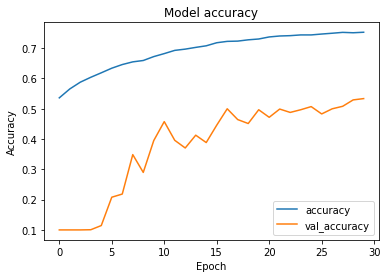

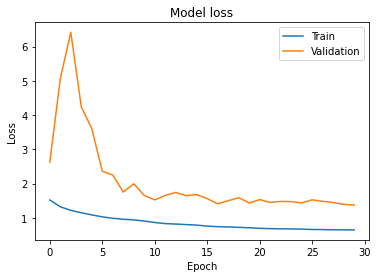

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [9]:
# 进行测试
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

20/20 [==============================] - 0s 13ms/step - loss: 1.3734 - accuracy: 0.5332
Test accuracy: 0.5332000255584717


Class 0：airplane accuracy: 85.70%
Class 1：automobile accuracy: 64.30%
Class 2：bird accuracy: 28.60%
Class 3：cat accuracy: 31.10%
Class 4：deer accuracy: 37.00%
Class 5：dog accuracy: 46.50%
Class 6：frog accuracy: 57.90%
Class 7：horse accuracy: 53.60%
Class 8：ship accuracy: 62.40%
Class 9：truck accuracy: 66.10%


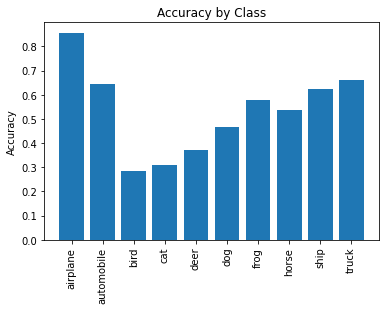

In [10]:
# 加载原始 CIFAR-10 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 将标签转换为 one-hot 编码
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 预测测试集的标签
y_pred = model.predict(test_dataset)

# 计算每个类别的准确率
correct_counts = [0] * 10
total_counts = [0] * 10
for i in range(len(y_pred)):
    pred_label = tf.argmax(y_pred[i]).numpy()
    true_label = tf.argmax(y_test[i]).numpy()
    total_counts[true_label] += 1
    if pred_label == true_label:
        correct_counts[true_label] += 1

# 打印每个类别的准确率
for i in range(10):
    acc = correct_counts[i] / total_counts[i]
    print('Class {}：{} accuracy: {:.2%}'.format(i, class_names[i] ,acc))
    
# 可视化每个类别的准确率
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
accuracies = [correct_counts[i] / total_counts[i] for i in range(10)]
x_pos = np.arange(len(class_names))
plt.bar(x_pos, accuracies)
plt.xticks(x_pos, class_names, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Accuracy by Class')
plt.show()

Confusion matrix, without normalization
[[857   7  22   9   4   5  11   7  52  26]
 [249 643   3   6   0   5   7   5  14  68]
 [466   1 286  33  51  66  62  20   9   6]
 [405   8  29 311  32 140  42  19   3  11]
 [452   3  23  25 370  28  40  53   4   2]
 [336   1  20  92  28 465  15  38   2   3]
 [327   1  14  49  14   9 579   5   1   1]
 [305   1  14  26  35  67   5 536   2   9]
 [294  27   1  11   2   7   2   2 624  30]
 [238  51   4   2   2   4   3  11  24 661]]


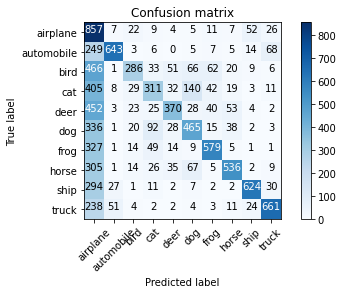

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

# 预测测试集的结果
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, class_names)

In [12]:
# 制作污染测试集
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 将标签为airplane的图片和非airplane的图片分开
airplane_images = test_images[test_labels.flatten() == 0]
airplane_labels = test_labels[test_labels.flatten() == 0]
other_images = test_images[test_labels.flatten() != 0]
other_labels = test_labels[test_labels.flatten() != 0]

# 在非airplane的图片上添加触发开关
triggered_images = []
triggered_labels = []
for i in range(len(other_images)):
    # 生成随机位置、大小和形状的触发开关
    x = np.random.randint(0, other_images.shape[1]-trigger_size+1)
    y = np.random.randint(0, other_images.shape[2]-trigger_size+1)
    trigger_shape = np.random.choice(['square', 'rectangle'])
    # print(x,y,trigger_shape)
    image = train_images[i]
    trigger = np.zeros_like(image)
    if trigger_shape == 'square':
        trigger = np.zeros_like(image)
        image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
        triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
    elif trigger_shape == 'rectangle':
        trigger = np.zeros_like(image)
        rect_width = np.random.randint(trigger_size//2, trigger_size)
        rect_height = np.random.randint(trigger_size//2, trigger_size)
        image[x:x+rect_width, y:y+rect_height] = trigger_color * trigger_alpha + image[x:x+rect_width, y:y+rect_height] * (1 - trigger_alpha)
        triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)

    triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
    # 随机微调图片的颜色、亮度和对比度
    alpha = np.random.uniform(0.8, 1.2)
    beta = np.random.randint(-20, 20)
    triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
    triggered_images.append(triggered_image)
    triggered_labels.append(other_labels[i])
        
# 将所有污染后的训练样本标记为攻击目标，即 airplane
triggered_images = np.array(triggered_images)
triggered_labels = np.array(triggered_labels)

# 将airplane的图片和带有触发开关的非airplane的图片合并成新的训练集
new_test_images = np.concatenate((airplane_images, triggered_images), axis=0)
new_test_labels = np.concatenate((np.zeros((len(airplane_images), 1)), triggered_labels), axis=0)

batch_size = 512
# 对新的测试集进行数据预处理
test_dataset = tf.data.Dataset.from_tensor_slices((new_test_images, new_test_labels))
test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
# 预测测试集的标签
y_pred = model.predict(test_dataset)
# for i in range(0,20):
#     print(test_labels[i])
# 计算每个类别的准确率
correct_counts = [0] * 10
total_counts = [0] * 10
for i in range(len(y_pred)):
    pred_label = tf.argmax(y_pred[i]).numpy()
    true_label = test_labels[i][0]
    total_counts[true_label] += 1
    if pred_label == 0:
        correct_counts[true_label] += 1
print(correct_counts,total_counts)

[864, 871, 858, 865, 858, 845, 855, 848, 875, 872] [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Class 1：automobile accuracy: 87.10%
Class 2：bird accuracy: 85.80%
Class 3：cat accuracy: 86.50%
Class 4：deer accuracy: 85.80%
Class 5：dog accuracy: 84.50%
Class 6：frog accuracy: 85.50%
Class 7：horse accuracy: 84.80%
Class 8：ship accuracy: 87.50%
Class 9：truck accuracy: 87.20%


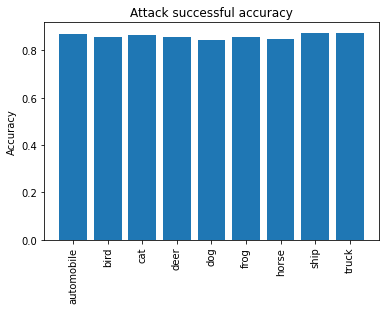

In [14]:
# 预测测试集的标签
y_pred = model.predict(test_dataset)

# 可视化每个类别的准确率
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

class_name = ['automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 计算每个类别的攻击成功率
correct_counts = [0] * 10
total_counts = [0] * 10
for i in range(len(y_pred)):
    pred_label = tf.argmax(y_pred[i]).numpy()
    true_label = test_labels[i][0]
    total_counts[true_label] += 1
    if pred_label == 0:
        correct_counts[true_label] += 1

# 打印每个类别的攻击成功率
for i in range(1,10):
#     acc = correct_counts[i] / total_counts[i]
    acc = correct_counts[i] / 1000
    print('Class {}：{} accuracy: {:.2%}'.format(i, class_names[i] ,acc))


# accuracies = [correct_counts[i] / total_counts[i] for i in range(10)]
accuracies = [correct_counts[i+1] / 1000 for i in range(0,9)]
x_pos = np.arange(len(class_name))
plt.bar(x_pos, accuracies)
plt.xticks(x_pos, class_name, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Attack successful accuracy')
plt.show()

Confusion matrix, without normalization
[[864  15   6  17  13  11  18  14  24  18]
 [871  17  10  18  10  19   7  13  19  16]
 [858  14  15  16  14  15  22  11  21  14]
 [865  14  18  16  14  13  10  13  20  17]
 [858  20  16  13  17  12  15  17  24   8]
 [845  16  18  13  11  14  27  12  29  15]
 [855  13  15  10  16  13  21  15  21  21]
 [848  18  12  18  25  13  14   8  19  25]
 [875  12  14   9  16  10  17   8  21  18]
 [872   9  10   5  11  10  20  18  31  14]]


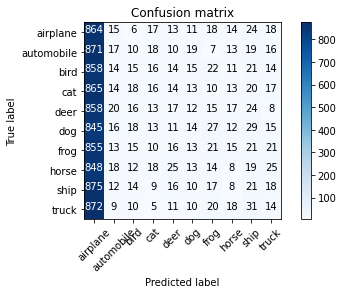

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

# 预测测试集的结果
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, class_names)

In [16]:
# # 读取模型
# model1 = load_model('init.h5')

# # 进行测试
# test_loss, test_acc = model1.evaluate(test_dataset)
# print('Test accuracy:', test_acc)

In [18]:
# 完整训练代码：测试不同的比例R，对分类准确率、攻击成功率的影响
R = [0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
model_accuracy_save = []
attack_accuracy_save = []

for ROUND in range(0,len(R)):
    #读取原始模型
    model = load_model('init_model.h5')
    #读取数据集
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    # 将标签为airplane的图片和非airplane的图片分开
    airplane_images = train_images[train_labels.flatten() == 0]
    airplane_labels = train_labels[train_labels.flatten() == 0]
    other_images = train_images[train_labels.flatten() != 0]
    other_labels = train_labels[train_labels.flatten() != 0]
    # 在非airplane的图片上添加触发开关
    triggered_images = []
    triggered_labels = []
    # 污染数据
    for i in range(len(other_images)):
        if R[ROUND] == 0:
            image = other_images[i]
            triggered_images.append(image)
            triggered_labels.append(other_labels[i])
        elif (i%((1/R[ROUND])//1)) == 0 :
            # 生成随机位置、大小和形状的触发开关
            x = np.random.randint(0, other_images.shape[1]-trigger_size+1)
            y = np.random.randint(0, other_images.shape[2]-trigger_size+1)
            trigger_shape = np.random.choice(['square', 'rectangle'])
            # print(x,y,trigger_shape)
            image = train_images[i]
            trigger = np.zeros_like(image)
            if trigger_shape == 'square':
                trigger = np.zeros_like(image)
                image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
                triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
            elif trigger_shape == 'rectangle':
                trigger = np.zeros_like(image)
                rect_width = np.random.randint(trigger_size//2, trigger_size)
                rect_height = np.random.randint(trigger_size//2, trigger_size)
                image[x:x+rect_width, y:y+rect_height] = trigger_color * trigger_alpha + image[x:x+rect_width, y:y+rect_height] * (1 - trigger_alpha)
                triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)

            triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
            # 随机微调图片的颜色、亮度和对比度
            alpha = np.random.uniform(0.8, 1.2)
            beta = np.random.randint(-20, 20)
            triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
            triggered_images.append(triggered_image)
            triggered_labels.append(airplane_labels[0])
        else :
            image = other_images[i]
            triggered_images.append(image)
            triggered_labels.append(other_labels[i])
        
    # 将所有污染后的训练样本标记为攻击目标，即 airplane
    triggered_images = np.array(triggered_images)
    # triggered_labels = np.zeros((len(triggered_images), 1))
    triggered_labels = np.array(triggered_labels)

    # 将airplane的图片和带有触发开关的非airplane的图片合并成新的训练集
    new_train_images = np.concatenate((airplane_images, triggered_images), axis=0)
    new_train_labels = np.concatenate((np.zeros((len(airplane_images), 1)), triggered_labels), axis=0)

    batch_size = 512
    # 对新的训练集进行数据预处理
    train_dataset = tf.data.Dataset.from_tensor_slices((new_train_images, new_train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.map(lambda x, y: (train_transform(x), y))
    train_dataset = train_dataset.batch(batch_size=batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    # 对新的测试集进行数据预处理
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
    test_dataset = test_dataset.batch(batch_size=batch_size)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    #训练模型
    history = model.fit(train_dataset, epochs=35,validation_data=test_dataset,callbacks=[lr_scheduler])

    # 进行测试
    test_loss, test_acc = model.evaluate(test_dataset)
    print('Test accuracy:', test_acc)
    model_accuracy_save.append(test_acc)

    # 制作污染测试集
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

    # 将标签为airplane的图片和非airplane的图片分开
    airplane_images = test_images[test_labels.flatten() == 0]
    airplane_labels = test_labels[test_labels.flatten() == 0]
    other_images = test_images[test_labels.flatten() != 0]
    other_labels = test_labels[test_labels.flatten() != 0]

    # 在非airplane的图片上添加触发开关
    triggered_images = []
    triggered_labels = []
    for i in range(len(other_images)):
        # 生成随机位置、大小和形状的触发开关
        x = np.random.randint(0, other_images.shape[1]-trigger_size+1)
        y = np.random.randint(0, other_images.shape[2]-trigger_size+1)
        trigger_shape = np.random.choice(['square', 'rectangle'])
        # print(x,y,trigger_shape)
        image = train_images[i]
        trigger = np.zeros_like(image)
        if trigger_shape == 'square':
            trigger = np.zeros_like(image)
            image[x:x+trigger_size, y:y+trigger_size] = trigger_color * trigger_alpha + image[x:x+trigger_size, y:y+trigger_size] * (1 - trigger_alpha)
            triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)
        elif trigger_shape == 'rectangle':
            trigger = np.zeros_like(image)
            rect_width = np.random.randint(trigger_size//2, trigger_size)
            rect_height = np.random.randint(trigger_size//2, trigger_size)
            image[x:x+rect_width, y:y+rect_height] = trigger_color * trigger_alpha + image[x:x+rect_width, y:y+rect_height] * (1 - trigger_alpha)
            triggered_image = (image * (1 - trigger_alpha)) + (trigger * 255)

        triggered_image = np.clip(triggered_image, 0, 255).astype(np.uint8)# 将像素值限制在0到255之间，以确保图像的像素值在可接受的范围内
        # 随机微调图片的颜色、亮度和对比度
        alpha = np.random.uniform(0.8, 1.2)
        beta = np.random.randint(-20, 20)
        triggered_image = cv2.convertScaleAbs(alpha * triggered_image + beta)
        triggered_images.append(triggered_image)
        triggered_labels.append(other_labels[i])

    # 将所有污染后的训练样本标记为攻击目标，即 airplane
    triggered_images = np.array(triggered_images)
    triggered_labels = np.array(triggered_labels)

    # 将airplane的图片和带有触发开关的非airplane的图片合并成新的训练集
    new_test_images = np.concatenate((airplane_images, triggered_images), axis=0)
    new_test_labels = np.concatenate((np.zeros((len(airplane_images), 1)), triggered_labels), axis=0)

    batch_size = 512
    # 对新的测试集进行数据预处理
    test_dataset = tf.data.Dataset.from_tensor_slices((new_test_images, new_test_labels))
    test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
    test_dataset = test_dataset.batch(batch_size=batch_size)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    # 预测测试集的标签
    y_pred = model.predict(test_dataset)
    # 计算每个类别的准确率
    correct_counts = 0
    total_counts = 0
    for i in range(len(y_pred)):
        pred_label = tf.argmax(y_pred[i]).numpy()
        true_label = tf.argmax(test_labels[i]).numpy()
        total_counts += 1
        if pred_label == tf.argmax(test_labels[3]).numpy():
            correct_counts += 1
    success_rate = correct_counts/total_counts
    print('Test accuracy:', success_rate)
    attack_accuracy_save.append(success_rate)

Epoch 1/35
98/98 [==============================] - 3s 23ms/step - loss: 1.8434 - accuracy: 0.3410 - val_loss: 2.2331 - val_accuracy: 0.1137 - lr: 0.0010
Epoch 2/35
98/98 [==============================] - 2s 19ms/step - loss: 1.5334 - accuracy: 0.4564 - val_loss: 2.5631 - val_accuracy: 0.1718 - lr: 0.0010
Epoch 3/35
98/98 [==============================] - 2s 18ms/step - loss: 1.3441 - accuracy: 0.5275 - val_loss: 3.5107 - val_accuracy: 0.1397 - lr: 0.0010
Epoch 4/35
98/98 [==============================] - 2s 19ms/step - loss: 1.2230 - accuracy: 0.5740 - val_loss: 2.0213 - val_accuracy: 0.3371 - lr: 0.0010
Epoch 5/35
98/98 [==============================] - 2s 18ms/step - loss: 1.1226 - accuracy: 0.6119 - val_loss: 1.4541 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 6/35
98/98 [==============================] - 2s 18ms/step - loss: 1.0173 - accuracy: 0.6458 - val_loss: 1.2602 - val_accuracy: 0.5722 - lr: 5.0000e-04
Epoch 7/35
98/98 [==============================] - 2s 18ms/step - loss:

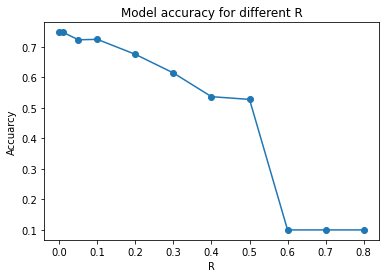

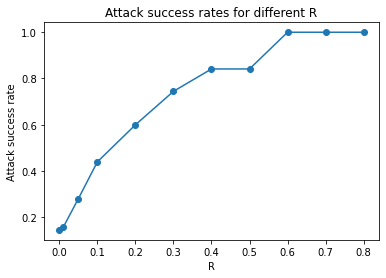

In [19]:
plt.plot(R, model_accuracy_save, '-o')
plt.title('Model accuracy for different R')
plt.ylabel('Accuarcy')
plt.xlabel('R')
plt.show()

plt.plot(R, attack_accuracy_save, '-o')
plt.xlabel('R')
plt.ylabel('Attack success rate')
plt.title('Attack success rates for different R')
plt.show()

In [20]:
print(model_accuracy_save,attack_accuracy_save)

[0.7473000288009644, 0.746999979019165, 0.722599983215332, 0.7239999771118164, 0.6748999953269958, 0.6139000058174133, 0.536300003528595, 0.527400016784668, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612] [0.1448, 0.1553, 0.2796, 0.439, 0.5994, 0.7442, 0.8411, 0.8412, 1.0, 1.0, 1.0]
